# Detecting Faces

## Imports

In [66]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib as mpl

## Data Visualisation & Structuring

In [35]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchsampler import ImbalancedDatasetSampler
from collections import Counter
import cv2

In [36]:
#from torchsampler import ImbalancedDatasetSampler

In [14]:
# Transfer data to tensor vectors and training/ testing datasets
train_dir = './start_deep/train_images'
test_dir = './start_deep/test_images'

transform = transforms.Compose(
    [transforms.Grayscale(), 
     transforms.ToTensor(), 
     transforms.Normalize(mean=(0,),std=(1,))])

train_data = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=transform)

valid_size = 0.2
batch_size = 32

num_train = len(train_data)
print("len(train_data)",len(train_data))
print ("len(test_data)", len(test_data))
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

train_sampler = ImbalancedDatasetSampler(train_data, train_new_idx)
valid_sampler = ImbalancedDatasetSampler(train_data, valid_idx)

#train_sampler = SubsetRandomSampler(train_new_idx)
#valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)
classes = ('noface','face')

# for epoch in range(1, n_epochs+1):
# for data, target in train_loader:


len(train_data) 91720
len(test_data) 7628


### Looking more in depth at our data

In [37]:
count_train_face = 0
count_train_no_face = 0
for data, target in train_loader:
    s = np.array(target).sum()
    count_train_face +=s
    count_train_no_face += batch_size - s

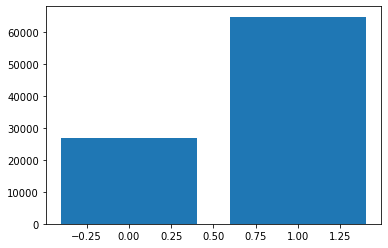

In [16]:
plt.bar(*zip(*dict(Counter(train_data.targets)).items()))
plt.show()

In [17]:
print(count_train_no_face, count_train_face)

21540 51836


In [18]:
count_test_face = 0
count_test_no_face = 0
for data, target in test_loader:
    s = np.array(target).sum()
    count_test_face +=s
    count_test_no_face += batch_size - s

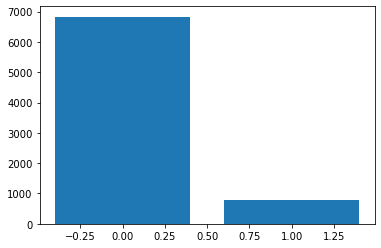

In [19]:
plt.bar(*zip(*dict(Counter(test_data.targets)).items()))
plt.show()

In [20]:
print(count_test_no_face, count_test_face)

6851 797


In [21]:
count_valid_face = 0
count_valid_no_face = 0
for data, target in valid_loader:
    s = np.array(target).sum()
    count_valid_face +=s
    count_valid_no_face += batch_size - s

In [22]:
print(count_valid_face, count_valid_no_face)

12934 5434


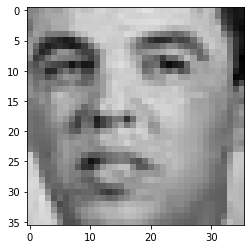

In [23]:
img = cv2.imread('./start_deep/train_images/1/Image000605.pgm')
plt.imshow(img)
plt.show()

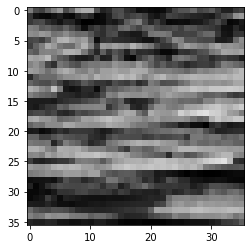

In [24]:
img = cv2.imread('./start_deep/train_images/0/137021_1_42_76_76.pgm')
plt.imshow(img)
plt.show()

## Building Model

In [25]:
###############################################
# Confusion Matrix 
# Input : output (of model), labels
# Output: average error
###############################################
class ConfusionMatrixMeter(object):     #same as for repSet
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.true_pos = 0
        self.true_neg = 0
        self.false_pos = 0
        self.false_neg = 0

    def update(self, output, target):
        for i in range(len(output)):
            if output[i][0]>output[i][1]: # predicted negative (no face)
                if target[i]==0:
                    self.true_neg +=1
                else:
                    self.false_neg +=1
            else:                         # predicted positive (face)
                if target[i]==1:
                    self.true_pos +=1
                else:
                    self.false_pos +=1



In [26]:
###############################################
# Description: error function to evaluate distance between prediction and label 
# Input : output (of model), labels
# Output: average error
###############################################
def error(output, labels):
    #print ("output",output)
    #print ("labels",labels)
    
    correct = 0
    predicted = torch.max(output.data, 1)[1] 
    correct += (predicted == labels).sum()
    return 1 - correct.item()/len(output.data)

In [27]:
###############################################
# Description: class used to keep count of the average error and loss during training
# Input : 
# Output:
###############################################
class AverageMeter(object):     #same as for repSet
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import log_loss

# Neural Network

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model 1: default
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(9 * 9 * 64, 100)
        self.fc2 = nn.Linear(100, 2)
        #self.sigmoid = nn.Sigmoid()
    
    def forward(self, X): # batch of n images
        #print ("input",X.size())
        out = self.layer1(X)
        #print ("after layer1",out.size())
        out = self.layer2(out)
        #print ("after layer2",out.size())
        out = out.reshape(out.size(0), -1)
        #print ("after reshape",out.size())
        out = self.drop_out(out)
        #print ("after drop",out.size())
        out = self.fc1(out)
        #print ("after fc1",out.size())
        out = self.fc2(out)
        #print ("after fc2",out.size())
        #out = F.log_softmax(out, dim=1)
        #print ("after log softmax",out.size())
        return out 

## Evaluating Model

In [30]:
from tqdm import tqdm

# Helpers

In [38]:
def show_image(images):
    image = torchvision.utils.make_grid(images, nrow=15)
    image = image / 2 + 0.5
    npimg = image.numpy()
    
    fig, ax = plt.subplots(figsize=(30, 30))
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

## Hyperparameters

In [58]:
epochs = 10
lr = 0.001
cv_folds = 1

In [59]:



for it in range(cv_folds):
    
    ### Set X and y tensors for training/valid/test set ###
    n_train_batches =len(train_loader)
    n_valid_batches = len(valid_loader)
    n_test_batches = len(test_loader)
    #n_test_batches = 250
    #n_train_batches =200
    #n_valid_batches = 50
    print("n_train_batches",n_train_batches)
    print("n_valid_batches",n_valid_batches)
    print("n_test_batches",n_test_batches)
    ############################################ - TRAIN, TEST FUNCTIONS
    def train(X, y):
        optimizer.zero_grad()
        output = model(X)
        loss_train = F.cross_entropy(output, y)
        #print (output)
        #print (y)
        loss_train.backward()
        optimizer.step()
        return output, loss_train
    
    def test(X, y):
        output = model(X)
        loss_test = F.cross_entropy(output, y)
        return output, loss_test 

    #Initialize Model
    model = ConvNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    
    start = time.perf_counter()       #time indicator 
    for epoch in range(epochs):
        
        # train loop
        model.train()
        startEpoch = time.perf_counter()    #time indicator
        train_loss = AverageMeter()
        train_err = AverageMeter()
        i =0
        for data, target in tqdm(train_loader):
            i+=1
            if i == n_train_batches:
                break
            output, loss = train(data, target)
            train_loss.update(loss.item(), output.size(0))
            train_err.update(error(output, target), output.size(0))
        
        # Validation Loop
        model.eval()
        test_loss = AverageMeter()
        test_err = AverageMeter()
        i = 0
        for data, target in tqdm(valid_loader):
            i+=1
            if i == n_valid_batches:
                break
            output, loss = test(data, target)
            test_loss.update(loss.item(), output.size(0))
            test_err.update(error(output, target), output.size(0)) 
        print("Cross-val iter:", '%02d' % (it+1), "epoch:", '%03d' % (epoch+1), "train_loss=", "{:.5f}".format(train_loss.avg),
        "train_err=", "{:.5f}".format(train_err.avg), "val_loss=", "{:.5f}".format(test_loss.avg),
        "val_err=", "{:.5f}".format(test_err.avg), "epoch_time=", "{:.5f}".format(time.perf_counter()-startEpoch))
    
    # test Loop
    false_pred = list()
    model.eval()
    test_loss = AverageMeter()
    test_err = AverageMeter()
    i=0
    cmm = ConfusionMatrixMeter()
    for data, target in tqdm(test_loader):
        i+=1
        if i == n_test_batches:
            break
        output, loss = test(data, target)
        cmm.update(np.array(output.detach()), np.array(target))
        test_loss.update(loss.item(), output.size(0))
        test_err.update(error(output.data, target.data), output.size(0)) 
        
        # Add to cumulated correct predictions
        _, predicted = torch.max(output.data, 1)
        #test_acc_cumu += (predicted == target).sum().item()
        #test_total += target.size(0)
        
        # Append false estimations
        false_index = torch.nonzero((predicted != target), as_tuple=True)[0].numpy()
        for i in false_index:
            false_pred.append(data[i])
        
    print("Cross-val iter:", '%02d' % (it+1),"test_loss=", "{:.5f}".format(test_loss.avg),
        "test_err=", "{:.5f}".format(test_err.avg), "cv time=", "{:.5f}".format(time.perf_counter() -start))   
    show_image(false_pred)

  0%|          | 0/2293 [00:00<?, ?it/s]

n_train_batches 2293
n_valid_batches 574
n_test_batches 239


  4%|▎         | 82/2293 [00:12<05:38,  6.53it/s]


KeyboardInterrupt: 

In [43]:
data = [[cmm.true_pos,cmm.false_pos,cmm.true_pos+cmm.false_pos],
        [cmm.false_neg,cmm.true_neg, cmm.false_neg+cmm.true_neg],
        [cmm.true_pos+cmm.false_neg, cmm.false_pos+cmm.true_neg,cmm.true_pos+cmm.false_neg+cmm.false_pos+cmm.true_neg]]
pd.DataFrame(data=data, index=["Face Detected", "No Face Detected","Total"], columns=["Face","No Face", "Total"], dtype=None, copy=False)

,Face,No Face,Total
Face Detected,461,445,906
No Face Detected,336,6386,6722
Total,797,6831,7628


In [44]:
#Precision Score - accuracy in predicting if a face is 
precison = cmm.true_pos/(cmm.true_pos+cmm.false_pos)
print ("Precision Score",precison)

Precision Score 0.5088300220750552


In [45]:
# Recall Score
recall = cmm.true_pos/(cmm.true_pos+cmm.false_neg)
print ("Recall Score",recall)

Recall Score 0.5784190715181933


In [46]:
# F1 Score - The harmonic mean of precision and recall
f1_score = 2*(precison*recall)/(precison+recall)
print ("F1 Score",f1_score)

F1 Score 0.541397533763946


### In depth look at our kernels

In [110]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list

# get all the model children as list
model_children = list(model.children())

# counter to keep count of the conv layers
counter = 0 

# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
        elif type(model_children[i]) == nn.Sequential:
            for j in range(len(model_children[i])):
                child = model_children[i][j]
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)


# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) ====> SHAPE: torch.Size([32, 1, 5, 5])
CONV: Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) ====> SHAPE: torch.Size([64, 32, 5, 5])


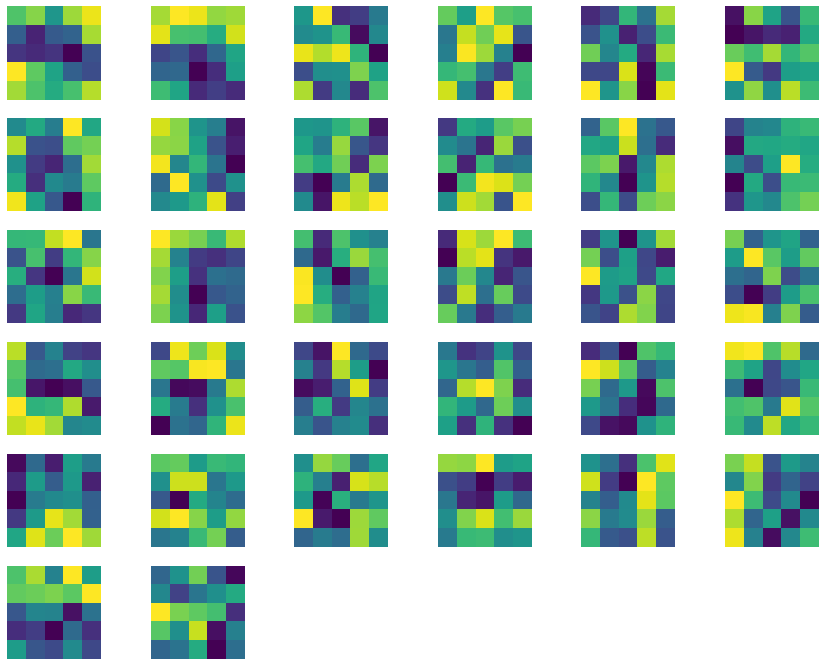

In [111]:
# visualize the first conv layer filters
plt.figure(figsize=(15, 12))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(6, 6, (i%36)+1) # (6, 6) because in conv0 we have 5x5 filters and 32 of them
    plt.imshow(filter[0, :, :].detach())
    plt.axis('off')
    #plt.savefig('../outputs/filter.png')
plt.show()

/opt/anaconda3/envs/pyTorch_projets/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


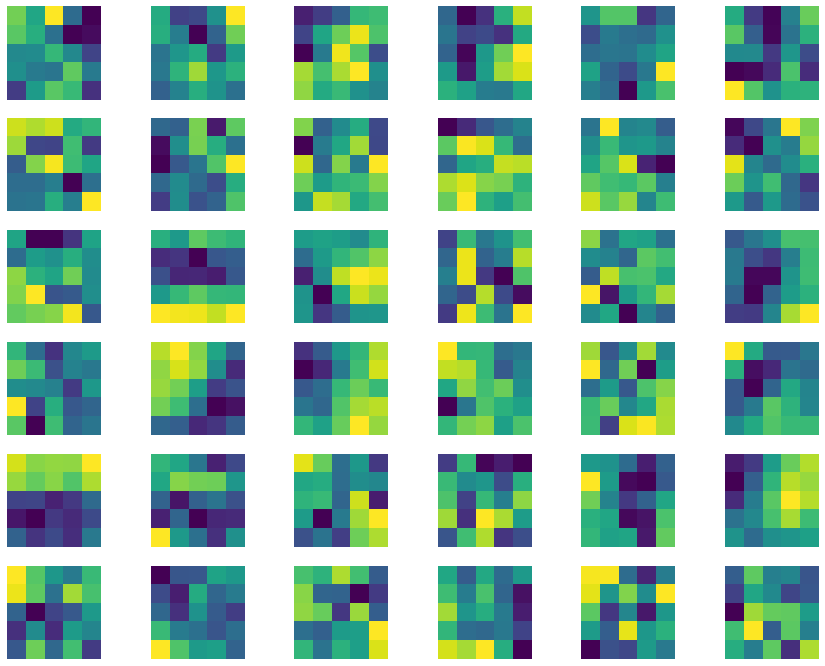

In [112]:
# visualize the first conv layer filters
plt.figure(figsize=(15, 12))
for i, filter in enumerate(model_weights[1]):
    plt.subplot(6, 6, (i%36)+1) # (6, 6) because in conv0 we have 5x5 filters and 32 of them
    plt.imshow(filter[0, :, :].detach())
    plt.axis('off')
    #plt.savefig('../outputs/filter.png')
plt.show()

# Saving Models

In [60]:
param_file_name = "97%acc_10epoch"
PATH = "./saved_models/"

# load model parameters file
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvNet().to(device)
model.load_state_dict(torch.load(PATH+"weights_"+param_file_name))

#load conmplet model
#model = torch.load(PATH +"model_"+ param_file_name)

<All keys matched successfully>

# Detector

In [69]:
import matplotlib as mpl


In [77]:
def gray_scale_image(path):
    an_image = mpl.image.imread('pics_with_faces/faces.jpg')
    #plt.imshow(an_image)
    rgb_weights = [0.2989, 0.5870, 0.1140]
    grayscale_image = np.dot(an_image[...,:3], rgb_weights)
    #plt.imshow(grayscale_image, cmap=plt.get_cmap("gray"))
    return grayscale_image

array([[193.9806, 193.9806, 193.9806, ..., 194.9805, 193.9806, 193.9806],
       [193.9806, 193.9806, 193.9806, ..., 193.9806, 193.9806, 193.9806],
       [194.9805, 194.9805, 194.9805, ..., 193.9806, 193.9806, 193.9806],
       ...,
       [249.747 , 249.975 , 249.975 , ..., 249.975 , 249.975 , 249.975 ],
       [249.747 , 249.975 , 249.975 , ..., 249.975 , 249.975 , 249.975 ],
       [249.747 , 249.975 , 249.975 , ..., 249.975 , 249.975 , 249.975 ]])

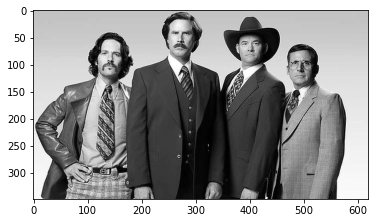

In [109]:
img = gray_scale_image('pics_with_faces/faces.jpg')
plt.imshow(, cmap=plt.get_cmap("gray"))
type(img)
img

In [100]:
class FaceDetector(object):
    def __init__(self, cnn):
        self.cnn = cnn
    
    # Method to draw box to delimit detected face
    def _draw(self):
        print (1)
    
    # Entry point, gets an image as input
    def detect(self, image):
        face_pos = list()
        x = len(image)
        y = len(image[0])
        # looping through all images of image (consider image big enough)
        for i in range (0,y-36, 4): 
            for j in range (0, x-36,4):
                # evaluate small image
                print (image)
                X = image[x:x+36,y:y+36]
                X = torch.from_numpy(X)
                print (X)
                output = self.cnn([[X]])
                self.cnn
                
                facteur = 1
                if (pred>0.9):
                    face_pos.append([x,y,facteur])
        
        
        return face_pos

In [105]:
fd = FaceDetector(model)
fd.detect(img)

[[193.9806 193.9806 193.9806 ... 194.9805 193.9806 193.9806]
 [193.9806 193.9806 193.9806 ... 193.9806 193.9806 193.9806]
 [194.9805 194.9805 194.9805 ... 193.9806 193.9806 193.9806]
 ...
 [249.747  249.975  249.975  ... 249.975  249.975  249.975 ]
 [249.747  249.975  249.975  ... 249.975  249.975  249.975 ]
 [249.747  249.975  249.975  ... 249.975  249.975  249.975 ]]
tensor([], size=(0, 0), dtype=torch.float64)


TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not list